In [ ]:
%matplotlib inline

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Desarrollo del Tp1 de Simulacion 2c2022


A member of the LXM family of algorithms for word size $w$ (where $w$ is any non-negative integer,
but typically either 64 or 32) consists of four components:
* L: a linear congruential pseudorandom number generator (LCG) with a $k$-bit state $s, k \geq w$
* X: an $F_2$-linear [L’Ecuyer and Panneton 2009] pseudorandom number generator (we use the 
term XBG, for "xor-based generator") with an $n$-bit state $x, n \geq w$
* a simple combining operation on two w-bit operands that produces a w-bit result
* M: a bijective mixing function that maps a $w$-bit argument to a $w$-bit result


The combining operation should have the property that if either argument is held constant, the resulting one-argument function is bijective; typically it is either binary integer addition ‘+’ or bitwise xor ‘⊕’ on $w$-bit words. In most practical applications $k$ and $n$ are integer multiples of $w$.  
The generate operation for an LXM generator is described by the following pseudocode, where global variable $s$ is the LCG state (a non-negative integer), global variable $t$ is the XBG state (a bit
vector), multiplier $m$ is an integer such that $(m \mod 8) = 5$, additive constant a is an odd integer,
and update matrix $U $is an $n×n$ matrix of bits. Elements of the product of matrix $U$ and a bit vector
of length $n$ are computed in the two-element field $F_2$ (addition is xor). In practice, $U$ is chosen so
that such matrix-vector products can be computed by using a small number of instructions such as
`xor`, `shift`, and `rotate` operating on w-bit words.

~~~
generate():
    z ← mix(combine(w high-order bits of s,w bits of t))
    s ← LCG_update(s)
    t ← XBG_update(t)
    return z
LCG_update(s) : return (m*s + a) mod 2^^k
XBG_update(t) : return U t
~~~

# Ejercicio 1

Sobre el generador de números al azar propuesto en el paper asignado, se pide:

● Implementarlo en función de lo especificado en el documento.

● Modificarlo (si aplica) para obtener números al azar entre 0 y 1

● Realizar los gráficos que se consideren adecuados para mostrar las distribuciones de números al azar
generados en ambos casos (explicar que se busca interpretar con cada uno)

In [ ]:
import matplotlib.pyplot as plt
from random import randint, random
from itertools import count, islice
from functools import partial
from typing import List, Tuple, Iterator, Callable
import numpy as np

In [ ]:
def combine_sum(bits: int, s: int, t: int):
    #return ((s >> (bits//2)) + (t >> (bits//2))) % (1 << bits)
    return (s + t) % (1 << bits)

def combine_xor(bits: int, s: int, t: int):
    #return ((s >> (bits//2)) ^ (t >> (bits//2))) % (1 << bits)
    return (s ^ t) % (1 << bits)

In [ ]:
def mix_lea64(z: int):
    bit_manip = lambda x: x ^ (x >> 32)
    modulo = (1 << 64)
    z = bit_manip(z) * 0xdaba0b6eb09322e3 % modulo
    z = bit_manip(z) * 0xdaba0b6eb09322e3 % modulo
    return bit_manip(z) % modulo

In [ ]:
def LCG(bits, m, a, s):
    return (m * s + a) % (1 << bits)

In [ ]:
def _rol(bits, n, d):
    """
    bits: bits totales del numero
    n: numero
    d: cantidad de bits a rotar a izquierda (d < bits)
    """
    return ((n << d)|(n >> (bits - d))) & ((1 << bits) - 1)
 
def _ror(bits, n, d):
    """
    bits: bits totales del numero
    n: numero
    d: cantidad de bits a rotar a derecha (d < bits)
    """
    return (n >> d)|(n << (bits - d)) & ((1 << bits) - 1)

rol64 = partial(_rol, 64)
ror64 = partial(_ror, 64)


def XBG_xoroshiro128v1(x0, x1):
    q0, q1 = x0, x1
    q1 ^= q0
    q0 = rol64(q0, 24)
    q0 = q0 ^ q1 ^ ((q1 << 16) % (1 << 64))
    q1 = rol64(q1, 37)
    return q0, q1

In [ ]:
def LXMg(s, x0, x1, *, mix, combine, lcg, xbg):
    """
    Generador LXM genérico

    Esta función toma distintos subgeneradores junto con distintas 
    funciones de mezclado y combinacion para armar un 
    generador concreto LXM en base a esos subgeneradores y demas.  

    s, x0, x1: semilla del generador. x0 y x1 no pueden 
        ser 0 simultaneamente. x0 y x1 son las semillas 
        del generador xbg.  
    mix: funcion de mezclado  
    combine: funcion de combinacion de 2 numeros en 
        forma bitwise  
    lcg: generador linealmente congruente. Toma un valor y 
        devuelve el siguiente.  
    xbg: generador xbg. Toma 2 valores y devuelve 
        los 2 siguientes

    devuelve: un generador de números que genera tantos números 
        como sean necesarios. (Usar junto con `islice` de `itertools`)
    """
#    assert x0 | x1 != 0, "x0 y x1 no pueden ser ambos 0"

    while True:
        z = mix(combine(s, x0))

        s = lcg(s)

        x0, x1 = xbg(x0, x1)

        yield z

In [ ]:
combine64 = partial(combine_sum, 64)
lcg64_1 = partial(LCG, 64, 0xd1342543de82ef95, 51)

lxm = partial(LXMg, mix=mix_lea64, combine=combine64, lcg=lcg64_1, xbg=XBG_xoroshiro128v1)

definimos una funcion que tome al generador y devuelva otro generador que devuelva valores con una distribucion uniforme entre 0 y 1

In [ ]:
def uniform_builder(generadorFn: Callable[[], Iterator[int]]):
    def _uniform(a=0, b=1, *, resolucion=5):
        generador = generadorFn() # cada llamada a _uniform() usa un generador nuevo (reiniciado)
        normalizar = lambda x: (x % (10**resolucion))/(10**resolucion)
        return (a + normalizar(x)*(b-a) for x in generador)
    return _uniform

In [ ]:
semilla_lxm = (1895, 469, 578823)
default_lxm = partial(lxm, *semilla_lxm)

default_lxm_uniform = uniform_builder(default_lxm)

testeando el generador

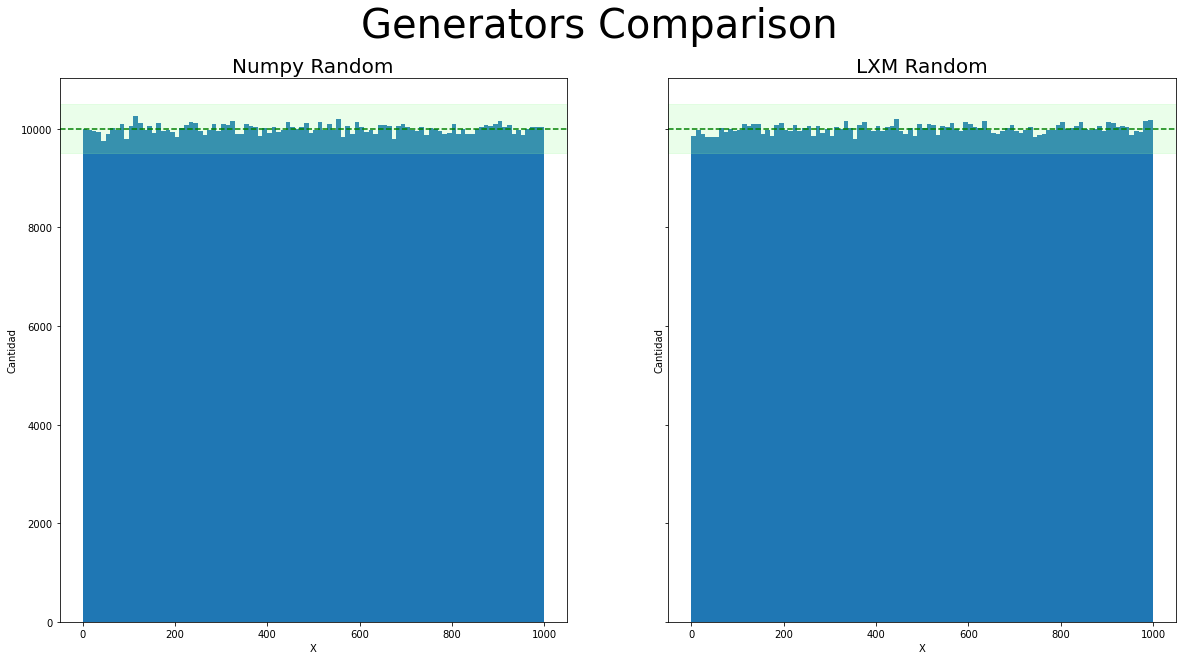

In [ ]:
numeros = 1_000_000

x = [i for i in range(numeros)]
gen = lxm(1895, 469, 578823)
y1 = [i % 1000 for i in islice(gen, numeros)]

y_np = np.random.default_rng().integers(0,1000,numeros)
fig, ax = plt.subplots(1,2, sharey=True, figsize = (20, 10))

h_np = ax[0].hist(y_np, 100)
ax[0].set_title("Numpy Random", fontsize = 20)
ax[0].axhspan(9500, 10500, alpha=0.2, color = "palegreen")
ax[0].axhline(10000, linestyle = "--", color = "green")
ax[0].set_xlabel('X')
ax[0].set_ylabel('Cantidad')
h1 = ax[1].hist(y1, 100)
ax[1].set_title("LXM Random", fontsize = 20)
ax[1].axhspan(9500, 10500, alpha=0.2, color = "palegreen")
ax[1].axhline(10000, linestyle = "--", color = "green")
ax[1].set_xlabel('X')
ax[1].set_ylabel('Cantidad')
plt.suptitle("Generators Comparison", fontsize = 40)
plt.show() 

In [ ]:
f"{len(y1):,}"

'1,000,000'

In [ ]:
muestras = [y_np, y1]
medias = [sum(x)/len(x) for x in muestras]
varianzas = [[(x - 500)**2 for x in m] for m in muestras]
varianzas = [sum(x)/(len(x)-1) for x in varianzas]

In [ ]:
list(zip(medias, varianzas))

[(499.551871, 83269.1726041726), (500.067384, 83258.92815292816)]

In [ ]:
bins = [h_np[0], h1[0]]
mean_bins = [x.mean() for x in bins]
var_bins = [x.var() for x in bins]
list(zip(mean_bins, var_bins))

[(10000.0, 8837.98), (10000.0, 8308.24)]

# Ejercicio 2

Para los generadores implementados en el ejercicio 1:

● Proponer, y realizar, al menos 3 tests para evaluar su comportamiento.

● Evaluar e interpretar los resultados de cada test para distintos tamaños de muestras.

# Test chi2 con nivel de significacion 0.05

In [ ]:
#Importamos el test chi2
from scipy.stats import chisquare
import numpy as np
import math

In [ ]:
def frecuencias(bins, vec, min, max):
  gap = (max - min)/bins

  frecuencias = []
  frecuencias.append(vec[(vec < gap)].size)
  for i in np.arange(gap, max-(gap), gap):
      frecuencias.append(vec[(vec >= i) & (vec < i + gap)].size)
  frecuencias.append(vec[(vec >= max-gap)].size)

  return np.array(frecuencias)

In [ ]:
from scipy.stats import chi2
def testChi2v2(generador, cantidad_muestras):
  max = 100
  bins = 20
  y = np.array([i%max for i in islice(generador,cantidad_muestras)])
  plt.hist(y, bins = 20)
  average = cantidad_muestras/bins
  plt.title("Frecuencias con n ="+str(cantidad_muestras), fontsize = 15)
  plt.xlabel("x", fontsize = 10)
  plt.ylabel("Frecuencias", fontsize = 10)
  plt.axhspan(average*1.05, average*0.95, alpha=0.2, color = "palegreen")
  plt.axhline(average, linestyle = "--", color = "green")
  
  frecuencias_observadas = frecuencias(bins, y, 0, max)


  estadistico = sum([(fO - 1/bins*cantidad_muestras)**2 for fO in frecuencias_observadas])/(1/bins*cantidad_muestras)
  limiteSuperior = chi2.ppf(0.95, df=bins-1) 

  print(f"Frecuencias {frecuencias_observadas}")
  print("Estadistico: {:.2f} ".format(estadistico))
  print("Limite: {:.2f} ".format(limiteSuperior))

  conclusion="Se rechaza H0" if estadistico>limiteSuperior else "No existe evidencia para rechazar H0"
  print(conclusion)

Frecuencias [2470 2405 2445 2486 2561 2492 2568 2492 2427 2537 2469 2533 2508 2440
 2535 2524 2516 2529 2574 2489]
Estadistico: 17.01 
Limite: 30.14 
No existe evidencia para rechazar H0


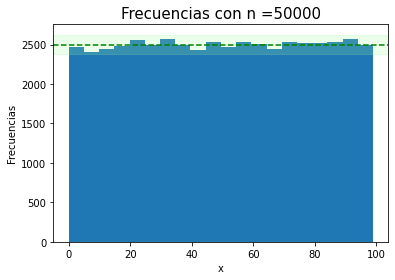

In [ ]:
gen = default_lxm()
testChi2v2(gen, 50000)

Hipótesis Nula: Es una distribución uniforme

Tanto mediante el gráfico como mediante el estadistico podemos ver que la distribución se acerca a la esperada con al menos un 95% de precisión. Lo cual no asegura que la distribución sea uniforma, simplemente no nos rechaza la hipótesis.

# Test de Independencia

In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [ ]:
def testIndependencia(generador, cantidad_muestras):
  nrosX = [(i%1000)/1000 for i in islice(generador,cantidad_muestras)]
  nrosY = [(i%1000)/1000 for i in islice(generador,cantidad_muestras)]

  chi2v, p, dof, ex = chi2_contingency([nrosX, nrosY], correction=True)
  print("Estadistico: ", chi2v)

  limiteSuperior = chi2.ppf(0.95, df=dof)
  print("Limite superior: ", limiteSuperior)

  conclusion="Se rechaza H0"if chi2v>limiteSuperior else "No existe evidencia para rechazar H0"
  print(conclusion)

In [ ]:
testIndependencia(default_lxm(), 10000)

Estadistico:  1845.4571446350205
Limite superior:  10232.737266236883
No existe evidencia para rechazar H0


Hipótesis Nula: No hay correlación entre dos aleatorias generadas.

Mediante el estadistico podemos ver que la distribución no genera correlación consigo misma con al menos un 95% de precisión. Lo cual no asegura que esto no pase, simplemente no nos rechaza la hipótesis.

# Test Espectral

In [ ]:
def testEspectral(generador, cantidad_muestras):

    valores = np.array([i%1000 for i in islice(generador,cantidad_muestras)])

    matriz = np.reshape(valores, (-1, 2)) 
    print("Dimensiones (filas,cols) = {0}".format(matriz.shape))

    x, y = matriz.T
    plt.figure(figsize=(6, 4), dpi=100)
    plt.title('Test espectral')
    plt.xlabel("Muestra X")
    plt.ylabel("Muestra Y")
    plt.scatter(x, y, s=2)
    plt.show()

Dimensiones (filas,cols) = (2500, 2)


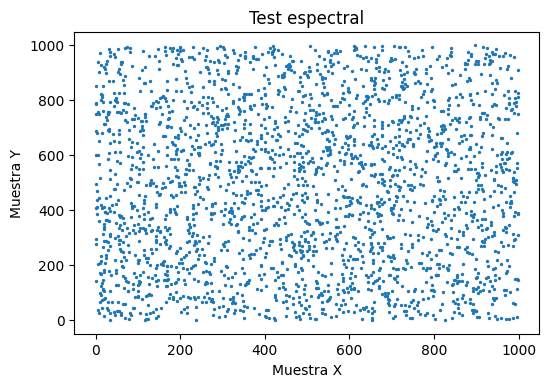

Dimensiones (filas,cols) = (5000, 2)


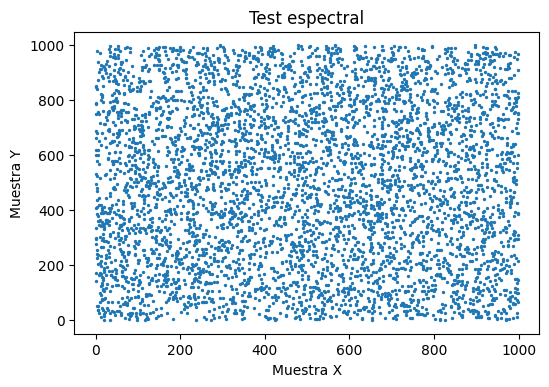

In [ ]:
testEspectral(default_lxm(), 5000)
testEspectral(default_lxm(), 10000)

In [ ]:
def testEspectral3D(generador, n: int):
    xs = [i%1000 for i in islice(generador,n)]
    ys = [i%1000 for i in islice(generador,n)]
    zs = [i%1000 for i in islice(generador,n)]


    fig = plt.figure(figsize=(5, 4), dpi=100)
    fig.set_tight_layout(True)

    
    fig.suptitle('Test espectral 3D')
    for i in range(1,4):
        ax = fig.add_subplot(2,2,i, projection='3d')
        ax.scatter(xs, ys, zs, s=2)
        ax.view_init(20+10*i,60*i)

    ax = fig.add_subplot(2,2,4, projection='3d')
    ax.scatter(xs, ys, zs, s=2)
    ax.view_init(90,0)
    
    plt.show()

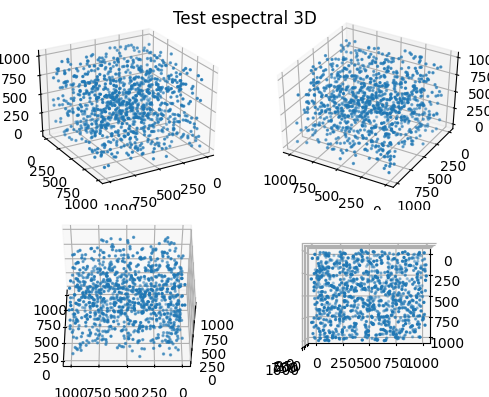

In [ ]:
testEspectral3D(default_lxm(), 1_000)

Viendo los gráficos podemos notar que no se encuentra ningun relación entre los puntos y que se distribuyen uniformememente a lo largo del plano, dando así una noción de uniformidad y de ausencia de correlación entre ellos.

# Ejercicio 3

Utilizando el generador implementado en el ejercicio 1:

● Implementar un método para generar variables aleatorias con distribución normal con media 10 y
desvío 2.

● Graficar la distribución que siguen los números pseudoaleatorios generados.

● Realizar, al menos 2 tests, de los explicados en la materia, para verificar si los números generados
siguen la distribución pedida (evalué los resultados para distintos tamaños de muestra).

In [ ]:
from scipy.stats import chisquare, anderson, expon, norm
import numpy as np
import math

## Método para generar variables aleatorias con distribución normal

In [ ]:
def obtener_muestra_normal(gen: Iterator[float], media, desvio, n=1_000):
	"""
	gen: generador (iterator) que retorna valores uniformes entre 0 y 1
	
	"""
	muestras_unif = np.array(list(islice(gen,1,n+1))) #el primero es 0
	muestra_normal = norm.ppf(muestras_unif, loc=media, scale=desvio)
	return muestra_normal[np.abs(muestra_normal) != np.inf]

## Test Chi-Cuadrado

In [ ]:
def obtener_frecuencias_observadas(valores_observados, min, max):
	frecuencias = [0 for i in range(min, max+2)]

	for i in valores_observados:
		if i <= min:
			frecuencias[0] += 1
		elif i >= max:
			frecuencias[-1] += 1
		else:
			frecuencias[math.floor(i) - min + 1] += 1

	return np.array(frecuencias)

In [ ]:
def obtener_frecuencias_esperadas(media, desvio, min, max, n):
  frecuencias_esperadas = []

  frecuencia = norm.cdf(min, media, desvio)
  frecuencias_esperadas.append(round(frecuencia * n))

  for i in range(min, max):
    frecuencia = norm.cdf(i+1, media, desvio) - norm.cdf(i, media, desvio)
    frecuencias_esperadas.append(round(frecuencia * n))
  
  #print(f"obt_frec_esp: frecuencias esperadas = {frecuencias_esperadas[:30]}")

  frecuencia = norm.sf(max, media, desvio)
  frecuencias_esperadas.append(round(frecuencia * n))

  return frecuencias_esperadas

In [ ]:
def test_chi_cuadrado(frecuencias_observadas, frecuencias_esperadas):
	estadistico, p_valor = chisquare(frecuencias_observadas, frecuencias_esperadas)
 
	print(f"El estadístico tiene un valor de {estadistico}")
	print(f"El p-valor es {p_valor}")

	if p_valor < 0.05:
		print("Se rechaza H0: la distribución NO es la esperada")

	else:
		print("No existe evidencia para rechazar H0: la distribución es la esperada")

## Test de Anderson-Darling

In [ ]:
def test_anderson_darling(valores_observados):
  resultado = anderson(valores_observados)

  for i in range(len(resultado.critical_values)):
    nivel_significancia = resultado.significance_level[i]/100
    estadistico = resultado.statistic
    valor_critico = resultado.critical_values[i]

    print(f"El estadístico es {estadistico} y el valor crítico es {valor_critico}")

    if estadistico > valor_critico:
      print(f"Con un nivel de significancia de {nivel_significancia} se rechaza H0: la distribución NO es normal")
    else:
      print(f"Con un nivel de significancia de {nivel_significancia} no existe evidencia para rechazar H0: la distribución es normal")

## n=10.000

In [ ]:
valores_observados = obtener_muestra_normal(default_lxm_uniform(resolucion=15), media=10, desvio=2, n=10_000)

In [ ]:
len(valores_observados)

10000

Text(0, 0.5, 'Frecuencias')

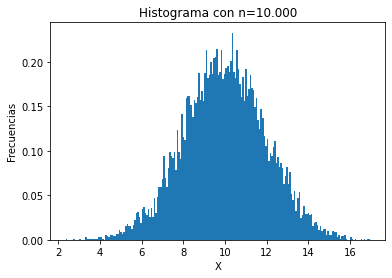

In [ ]:
import matplotlib.pyplot as plt
tachitos = 200
plt.hist(valores_observados, bins=tachitos, density=True)
plt.title('Histograma con n=10.000')
plt.xlabel('X')
plt.ylabel('Frecuencias')

Creo algunas muestras de la función real para graficar la verdadera curva

In [ ]:
x = np.linspace(0,20)
f_x = norm.pdf(x, 10,2)

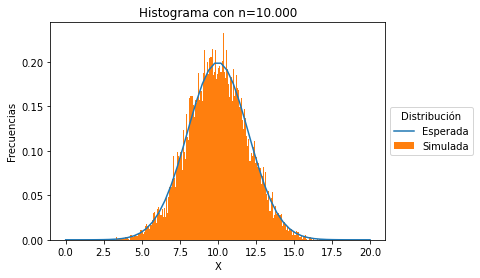

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, f_x)
plt.hist(valores_observados, density=True, bins=tachitos)
plt.title('Histograma con n=10.000')
plt.xlabel('X')
plt.ylabel('Frecuencias')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),title="Distribución",labels=["Esperada", "Simulada"])

In [ ]:
test_anderson_darling(valores_observados)

El estadístico es 0.3638852656004019 y el valor crítico es 0.576
Con un nivel de significancia de 0.15 no existe evidencia para rechazar H0: la distribución es normal
El estadístico es 0.3638852656004019 y el valor crítico es 0.656
Con un nivel de significancia de 0.1 no existe evidencia para rechazar H0: la distribución es normal
El estadístico es 0.3638852656004019 y el valor crítico es 0.787
Con un nivel de significancia de 0.05 no existe evidencia para rechazar H0: la distribución es normal
El estadístico es 0.3638852656004019 y el valor crítico es 0.918
Con un nivel de significancia de 0.025 no existe evidencia para rechazar H0: la distribución es normal
El estadístico es 0.3638852656004019 y el valor crítico es 1.092
Con un nivel de significancia de 0.01 no existe evidencia para rechazar H0: la distribución es normal


In [ ]:
frecuencias_observadas = obtener_frecuencias_observadas(valores_observados, 3, 16)

In [ ]:
frecuencias_esperadas = obtener_frecuencias_esperadas(media=10, desvio=2, min=3, max=16, n=len(valores_observados))

In [ ]:
sum(frecuencias_esperadas)

10000

In [ ]:
sum(frecuencias_observadas)

10000

In [ ]:
test_chi_cuadrado(frecuencias_observadas, frecuencias_esperadas)

El estadístico tiene un valor de 12.14479184784027
El p-valor es 0.5946760043192281
No existe evidencia para rechazar H0: la distribución es la esperada


## n=100.000

In [ ]:
valores_observados = obtener_muestra_normal(default_lxm_uniform(), media=10, desvio=2, n=100_000)

In [ ]:
len(valores_observados)

99999

In [ ]:
cont = 0
for i in valores_observados:
  if i < 0:
    print(cont)
  cont += 1

Text(0, 0.5, 'Frecuencias')

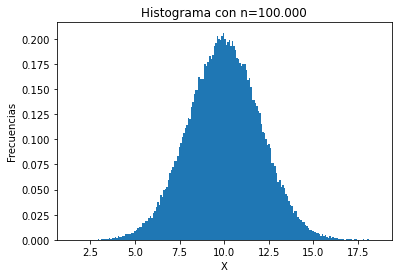

In [ ]:
import matplotlib.pyplot as plt

plt.hist(valores_observados, density=True, bins=tachitos)
plt.title('Histograma con n=100.000')
plt.xlabel('X')
plt.ylabel('Frecuencias')

Creo algunas muestras de la función real para graficar la verdadera curva

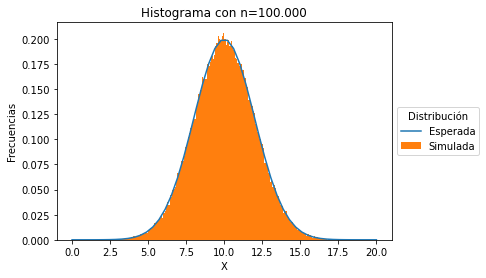

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, f_x)
plt.hist(valores_observados, density=True, bins=tachitos)
plt.title('Histograma con n=100.000')
plt.title('Histograma con n=100.000')
plt.xlabel('X')
plt.ylabel('Frecuencias')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),title="Distribución",labels=["Esperada", "Simulada"])

In [ ]:
test_anderson_darling(valores_observados)

El estadístico es 0.1724571545200888 y el valor crítico es 0.576
Con un nivel de significancia de 0.15 no existe evidencia para rechazar H0: la distribución es normal
El estadístico es 0.1724571545200888 y el valor crítico es 0.656
Con un nivel de significancia de 0.1 no existe evidencia para rechazar H0: la distribución es normal
El estadístico es 0.1724571545200888 y el valor crítico es 0.787
Con un nivel de significancia de 0.05 no existe evidencia para rechazar H0: la distribución es normal
El estadístico es 0.1724571545200888 y el valor crítico es 0.918
Con un nivel de significancia de 0.025 no existe evidencia para rechazar H0: la distribución es normal
El estadístico es 0.1724571545200888 y el valor crítico es 1.092
Con un nivel de significancia de 0.01 no existe evidencia para rechazar H0: la distribución es normal


In [ ]:
frecuencias_observadas = obtener_frecuencias_observadas(valores_observados, 3, 16)

In [ ]:
frecuencias_esperadas = obtener_frecuencias_esperadas(media=10, desvio=2, min=3, max=16, n=sum(frecuencias_observadas))

In [ ]:
sum(frecuencias_esperadas)

99999

In [ ]:
sum(frecuencias_observadas)

99999

In [ ]:
test_chi_cuadrado(frecuencias_observadas, frecuencias_esperadas)

El estadístico tiene un valor de 8.96048656886405
El p-valor es 0.8335734467672087
No existe evidencia para rechazar H0: la distribución es la esperada


#Ejercicio 4

La llegada de vehículos a un estacionamiento sigue un proceso de Poisson de tasa λ vehículos/hora. En el
trabajo práctico se incluye un archivo con números pseudoaleatorios que representan los tiempos entre arribos
de dichos vehículos.

● Realice una estimación de la tasa de arribos y proponga un test para evaluar si los números
pseudoaleatorios provistos siguen la distribución esperada.

● Utilizando el GCL implementado en el Ejercicio 1 simular la llegada de vehículos durante un mes. Graficar
la cantidad de arribos en función del tiempo.

● Generar 1000 realizaciones del proceso de Poisson para estimar las siguientes probabilidades:
1. Probabilidad que el primer vehículo arribe antes de los 10 minutos.
2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.
3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.

Comparar con los valores teóricos.

## Estimación de la tasa de arribos

Para estimar la tasa de arribos se sabe que el Estimador de Máxima Verosimilitud para el parámetro λ de una variable aleatoria con distribución Exponencial es la cantidad n de observaciones independientes e idénticamente distribuidas dividido la suma de esas observaciones obtenidas



In [ ]:
id='15w_ibkmQFOIC77bIMnb-qkggiaYNYGcR'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('tiempos_entre_arribos.txt')

In [ ]:
observaciones = []

with open('tiempos_entre_arribos.txt', 'r') as archivo:
  observaciones = [float(linea.rstrip()) for linea in archivo]

In [ ]:
tasa_de_arribos_estimada = len(observaciones) / sum(observaciones)

In [ ]:
tasa_de_arribos_estimada

9.889245996494681

## Test Chi-Cuadrado

In [ ]:
def obtener_frecuencias_esperadas_exponencial(lam, min, max, n):
  frecuencias_esperadas = []

  for i in np.arange(min, max, 0.1):
    frecuencia = expon.cdf(i+0.1, scale=lam) - expon.cdf(i, scale=lam)
    frecuencias_esperadas.append(round(frecuencia * n))

  frecuencia = expon.sf(max, scale=lam)
  frecuencias_esperadas.append(round(frecuencia * n))

  return frecuencias_esperadas

In [ ]:
def obtener_frecuencias_observadas(valores_observados, min, max):
  frecuencias = [0 for i in range(0, 8)]

  for i in valores_observados:
    if i <= 0.1:
      frecuencias[0] += 1
    elif i > 0.7:
      frecuencias[7] += 1
    else:
      frecuencias[math.floor(i * 10)] += 1
      
  return np.array(frecuencias)

In [ ]:
fe = obtener_frecuencias_esperadas_exponencial(lam=1/tasa_de_arribos_estimada, min=0, max=0.7, n=len(observaciones))

In [ ]:
fo = obtener_frecuencias_observadas(observaciones, 0, 0.7)

In [ ]:
test_chi_cuadrado(frecuencias_esperadas=fe, frecuencias_observadas=fo)

El estadístico tiene un valor de 6.707543952450168
El p-valor es 0.45995204147155133
No existe evidencia para rechazar H0: la distribución es la esperada


## Simulación de la llegada de vehículos durante un mes

Utilizo el método de la transformada inversa para generar muestras de una variable aleatoria con distribución exponencial

In [ ]:
import numpy as np

def exponencial(generador, lam, n=1000):
  valores = [i%1000/1000 for i in islice(generador, n)]

  muestras = [(-1 / lam) * np.log(1 - i) for i in valores]

  return muestras

Simulamos la llegada de vehiculos durante 744 hs = 1 mes

In [ ]:
tiempo_maximo = 744

tiempo_acumulado = 0
tiempos = []

generador = lxm(1895, 469, 578823)

while (tiempo_acumulado <= tiempo_maximo):
  z = exponencial(generador, tasa_de_arribos_estimada, n=1)[0]
  tiempo_acumulado += z
  tiempos.append(tiempo_acumulado)

Gráfico de la cantidad de arribos en función del tiempo durante un mes:

Text(0.5, 1.0, 'Simulación de la cantidad de arribos en función del tiempo durante un mes')

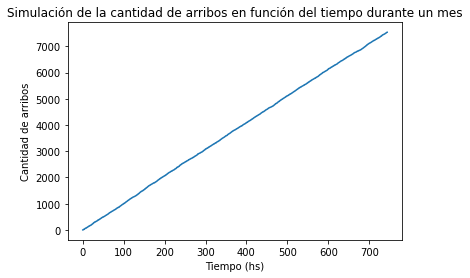

In [ ]:
plt.step(tiempos, range(len(tiempos)))
plt.xlabel('Tiempo (hs)')
plt.ylabel('Cantidad de arribos')
plt.title('Simulación de la cantidad de arribos en función del tiempo durante un mes')

## Probabilidad que el primer vehículo arribe antes de los 10 minutos

In [ ]:
casos_favorables = 0

for i in range(0, 1000):
  if exponencial(generador, tasa_de_arribos_estimada, n=1)[0] < 0.1:
    casos_favorables += 1

In [ ]:
casos_favorables / 1000

0.625


La probabilidad teórica es $P(X(0, 0.1) \geq 1) = 1 - P(X(0,0.1) < 1) = 1 - P(X(0,0.1) = 0) = 1 - \frac{(0.1 \lambda)^0 e^{-0.1 \lambda}}{0!} = 1 - e^{-0.1 \lambda}$

In [ ]:
1 - np.e ** (-0.1*tasa_de_arribos_estimada)

0.6280235003355337

In [ ]:
from scipy.stats import poisson

In [ ]:
poisson.sf(0, 0.1 * tasa_de_arribos_estimada)

0.6280235003355338

## Probabilidad que el undécimo vehículo arribe después de los 60 minutos

In [ ]:
casos_favorables = 0

for i in range(0, 1000):
  if sum(exponencial(generador, tasa_de_arribos_estimada, n=11)) > 1:
    casos_favorables += 1

In [ ]:
casos_favorables / 1000

0.636

La probabilidad teórica es $P(X(0, 1) \leq 10)$

In [ ]:
poisson.cdf(10, tasa_de_arribos_estimada)

0.5968933394416578

## Probabilidad que arriben al menos 750 vehículos antes de las 72 horas

In [ ]:
casos_favorables = 0

for i in range(0, 1000):
  if sum(exponencial(generador, tasa_de_arribos_estimada, n=750)) < 72:
    casos_favorables += 1

In [ ]:
casos_favorables / 1000

0.074

La probabilidad teórica es P(X(0, 72) >= 750)

In [ ]:
poisson.sf(750, 72 * tasa_de_arribos_estimada)

0.07559374302933504


#Ejercicio 5

A partir del generador de número al azar implementado en el ejercicio 1, y del dataset provisto, obtenido del
sitio de datos abiertos del Gobierno de la Ciudad de Buenos Aires (data.buenosaires.gob.ar), el cual contiene
información geográfica de barrios de la Ciudad de Buenos Aires, se pide:

● Proponer e implementar un método que permita generar coordenadas (latitud y longitud) distribuidas
de forma uniforme en cada uno de los barrios.

● Graficar los puntos generados en el mapa

In [ ]:
import os
import json
from shapely.geometry import Point, Polygon
from math import floor
import random
import matplotlib.pyplot as plt

In [ ]:
def find_limits(all_limits):
    min_x = 180
    max_x = -180
    min_y = 180
    max_y = -180
    for limits in all_limits[0]:
        for limit in limits:
            x = limit[0]
            y = limit[1]

            if x < min_x:
                min_x = x
            if x > max_x:
                max_x = x

            if y < min_y:
                min_y = y
            if y > max_y:
                max_y = y

    return min_x, max_x, min_y, max_y

In [ ]:
def read_json(file):
    if os.path.isfile(file):
        f = open(file, "r", encoding="utf-8")
        data = json.load(f)
        f.close()
    else:
        data = {}

    return data


In [ ]:
class Barrio():
    def __init__(self, name, all_limits, uniformGenerator):
        self.generator: Iterator[float] = uniformGenerator
        self.name = name.lower().capitalize()
        self.polygons = []
        for limits in all_limits[0]:
            new_one = Polygon(limits)
            self.polygons.append(new_one)
        min_x, max_x, min_y, max_y = find_limits(all_limits)
        self.max_x = min_x
        self.min_x = max_x
        self.min_y = min_y
        self.max_y = max_y

    def point_in_barrio(self, longitude, latitude):
        inside = False
        point = Point(longitude, latitude)
        for limit in self.polygons:
            if limit.contains(point):
                inside = True

        return inside

    def get_n_random_points(self, n):
        x_gap = self.max_x-self.min_x
        y_gap = self.max_y-self.min_y

        random_points_in = []

        while len(random_points_in) < n:
            x_rand = next(self.generator) * x_gap + self.min_x
            y_rand = next(self.generator) * y_gap + self.min_y
            if self.point_in_barrio(x_rand, y_rand):
                random_points_in.append([x_rand, y_rand])

        return random_points_in
      
    def get_n_points(self, n):
      x_gap = self.max_x-self.min_x
      y_gap = self.max_y-self.min_y

      random_points_in = []
      random_points_out = []

      while len(random_points_in) + len(random_points_out) < n:
          x_rand = next(self.generator) * x_gap + self.min_x
          y_rand = next(self.generator) * y_gap + self.min_y
          if self.point_in_barrio(x_rand, y_rand):
              random_points_in.append([x_rand, y_rand])
          else:
              random_points_out.append([x_rand, y_rand])

      return random_points_in, random_points_out

    def graph_limits(self, color):
        area = 0
        for polygon in self.polygons:
            x, y = polygon.exterior.xy
            plt.plot(x, y, color=color)
            area += polygon.area
        return area

    def graph_borders(self, color):
        borders = []
        borders.append([self.max_x, self.min_y])
        borders.append([self.max_x, self.max_y])
        borders.append([self.min_x, self.max_y])
        borders.append([self.min_x, self.min_y])
        polygon = Polygon(borders)
        x, y = polygon.exterior.xy
        plt.plot(x, y, color=color)
        return polygon.area

    def __eq__(self, other):
        return self.name == other.name

    def __lt__(self, other):
        return self.name < other.name

    def __le__(self, other):
        return self.name <= other.name

    def __gt__(self, other):
        return self.name > other.name

    def __ge__(self, other):
        return self.name >= other.name

In [ ]:
def get_barrios(file, generador):
    city_dict = read_json(file)
    barrios = city_dict.get("features")
    barrios_return = []
    for barrio in barrios:
        name = barrio.get("properties").get("BARRIO")
        limits = barrio.get("geometry").get("coordinates")
        barrio_class = Barrio(name, limits, generador)
        barrios_return.append(barrio_class)

    barrios_return.sort()

    return barrios_return


In [ ]:
def graph_points(points, color):
    x = []
    y = []
    for point in points:
        x.append(point[0])
        y.append(point[1])
    plt.scatter(x, y, color=color, s=1)

In [ ]:
COLORES = ['black', 'dimgray', 'dimgrey', 'gray', 'grey', 'darkgray',\
           'darkgrey', 'silver', 'gainsboro', 'rosybrown', 'indianred',\
           'brown', 'firebrick', 'maroon', 'darkred', 'red', 'mistyrose',\
           'salmon', 'tomato', 'darksalmon', 'coral', 'orangered', 'sienna',\
           'chocolate', 'saddlebrown', 'sandybrown', 'peachpuff', 'peru',\
           'bisque', 'darkorange', 'burlywood', 'papayawhip', 'moccasin',\
           'orange', 'wheat', 'darkgoldenrod', 'goldenrod', 'gold', 'lemonchiffon',\
           'khaki', 'palegoldenrod', 'darkkhaki', 'olive', 'yellow', 'olivedrab',\
           'yellowgreen', 'darkolivegreen', 'greenyellow', 'chartreuse', 'lawngreen',\
           'darkseagreen', 'palegreen', 'forestgreen', 'limegreen', 'darkgreen',\
           'green', 'lime', 'seagreen', 'mediumseagreen', 'springgreen',\
           'mediumspringgreen', 'mediumaquamarine', 'aquamarine', 'turquoise',\
           'mediumturquoise', 'paleturquoise', 'darkslategray', 'darkslategrey',\
           'teal', 'darkcyan', 'aqua', 'cyan', 'darkturquoise', 'cadetblue',\
           'powderblue', 'deepskyblue', 'skyblue', 'steelblue', 'dodgerblue',\
           'slategray', 'slategrey', 'cornflowerblue', 'royalblue', 'lavender',\
           'midnightblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue',\
           'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple',\
           'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid',\
           'thistle', 'plum', 'violet', 'purple', 'darkmagenta', 'fuchsia',\
           'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink',\
           'lavenderblush', 'palevioletred', 'crimson', 'pink']

In [ ]:
def main_acep_rech(generador, file, n):
    barrios = get_barrios(file, generador)
    barrio = barrios[31]

    randoms_in, randoms_out = barrio.get_n_points(n)
    n_in, n_out = len(randoms_in), len(randoms_out)
    graph_points(randoms_in, "green")
    graph_points(randoms_out, "red")

    area_limite = barrio.graph_limits("black")
    area_bordes = barrio.graph_borders("black")

    plt.title(barrio.name)

    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    ax = plt.gca()
    area_adentro = area_limite/area_bordes
    ax.text(
    *randoms_in[n_in//2], f"n = {len(randoms_in)}\n area = {area_adentro:.3%}", ha="center", va="center", size=15,
    bbox=dict(boxstyle="round", fc="green", alpha=0.6))
    ax.text(
    *randoms_out[n_out//2], f"n = {len(randoms_out)}\n area = {1 - area_adentro:.3%}", ha="center", va="center", size=15,
    bbox=dict(boxstyle="round", fc="red", alpha=0.6))

    plt.show()

In [ ]:
def main_all(generador, file, n):
    barrios = get_barrios(file, generador)

    colors_amount = len(COLORES)
    barrios_amount = len(barrios)
    gap = floor(colors_amount/barrios_amount)

    for i, barrio in enumerate(barrios):
        color = COLORES[i*gap]
        randoms_in = barrio.get_n_random_points(n)
        graph_points(randoms_in, color)
      
    for barrio in barrios:
        barrio.graph_limits("black")
      
    plt.title("Barrios CABA")
    plt.xlabel("Longitud")
    plt.xticks(rotation=-45)
    plt.ylabel("Latitud")
    ax = plt.gca()
    ax.set_aspect('equal')

    plt.show()

In [ ]:
id='1hlKvQ8UDAip10hPj1ghfql8NkjMk11mL'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('caba_barrios.json')

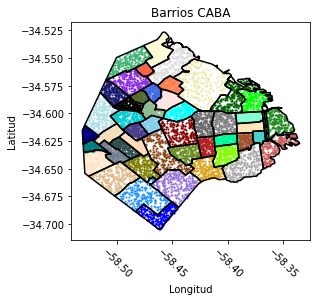

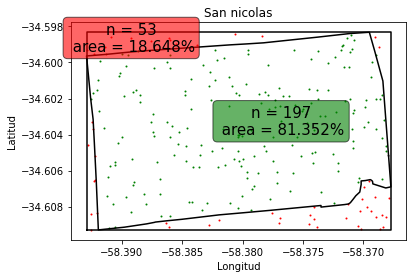

In [ ]:
genUnif = default_lxm_uniform()
main_all(genUnif, 'caba_barrios.json', 250)
main_acep_rech(genUnif, 'caba_barrios.json', 250)